In [ ]:
# default_exp utils.engine

In [ ]:
#export
import os
import time
import timeit
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from abc import ABC
from fastprogress.fastprogress import master_bar, progress_bar

In [ ]:
#export
class Fitter(ABC):
    def __init__(self):
        pass
    
    def fit(self):
        pass
    
    def log(self):
        pass
    
    def train(self):
        pass
    
    def validate(self):
        pass

In [ ]:
#export
class BertFitter(Fitter):
    def __init__(self, model, dataloaders, optimizer, metrics, device, log_file='training_log.txt',scheduler=None, trial=None):
        self.model = model
        self.train_dl, self.valid_dl = dataloaders[0], dataloaders[1]
        self.optimizer = optimizer
        self.scheduler = scheduler
        if not os.path.exists(os.path.join('..', 'outputs')): os.makedirs(os.path.join('..', 'outputs'))
        if os.path.exists(os.path.join('..', 'outputs', f'{log_file}')): 
            os.remove(os.path.join('..', 'outputs', f'{log_file}'))
        self.log_file = os.path.join('..', 'outputs', f'{log_file}')
        if not isinstance(metrics, (list, tuple)): 
            metrics = list(metrics)
        self.metrics = metrics
        self.device = device
        self.trial = trial #for optuna
        
    def fit(self, epochs, return_metric=False, 
            monitor='epoch train_loss valid_loss tag_accuracy tag_f1_score pos_accuracy pos_f1_score time', 
            model_path=os.path.join('..', 'weights', 'model.pth'), show_graph=True):
        self.model_path = model_path
        self.log(f'{time.ctime()}')
        self.log(f'Using device: {self.device}')
        mb = master_bar(range(1, epochs+1)) #MAJOR
        mb.write(monitor.split(),table=True)
        
        model = self.model.to(self.device)
        optimizer = self.optimizer
        best_metric = -np.inf
        train_loss, valid_loss = 0, 0
        valid_metric_0_tag, valid_metric_1_tag =  0, 0
        valid_metric_0_pos, valid_metric_1_pos =  0, 0
        train_loss_list, valid_loss_list = [], []
        
        for i_, epoch in enumerate(mb):
            epoch_start = timeit.default_timer()
            start = time.time()
            self.log('-'*50)
            self.log(f'Running Epoch #{epoch} {"🔥"*epoch}')
            self.log(f'{"-"*50} \n')
            self.log('TRAINING...')
            for ind, batch in enumerate(progress_bar(self.train_dl, parent=mb)):
                train_loss += self.train(batch, model, optimizer, self.device, self.scheduler)
                if ind % 500 == 0:
                    self.log(f'Batch: {ind}, Train loss: {train_loss/ len(self.train_dl)}')
#                 break
                mb.child.comment = f'{train_loss / (ind+1 * self.train_dl.batch_size):.3f}'
            train_loss /= mb.child.total
#             train_loss /= (ind+1)
            train_loss_list.append(train_loss) #for graph
            self.log(f'Training time: {round(time.time()-start, 2)} secs \n')
            
            start = time.time()
            self.log('EVALUATING...')
            with torch.no_grad():
                for ind, batch in enumerate(progress_bar(self.valid_dl, parent=mb)):
                    valid_loss_, valid_metric_ = self.validate(batch, model, self.device)
                    valid_loss += valid_loss_
                    valid_metric_0_tag += valid_metric_[0]
                    valid_metric_1_tag += valid_metric_[1]
                    valid_metric_0_pos += valid_metric_[2]
                    valid_metric_1_pos += valid_metric_[3]
                    if ind % 500 == 0:
                        self.log(f'Batch: {ind}, Valid loss: {valid_loss/ len(self.valid_dl)}')
#                     break   
                    mb.child.comment = f'{valid_loss / (ind+1 * self.train_dl.batch_size):.3f}'
                
                valid_loss /= mb.child.total
#                 valid_loss /= (ind+1)
#                 print(f"valid_metric_0_tag: {valid_metric_0_tag}")
#                 print(f"bs: {mb.child.total}")
                valid_metric_0_tag /= mb.child.total
#                 valid_metric_0_tag /= (ind+1)
                valid_metric_1_tag /= mb.child.total
#                 valid_metric_1_tag /= (ind+1)
#                 print(f"valid_metric_0_pos: {valid_metric_0_pos}")
#                 print(f"bs: {mb.child.total}")
                valid_metric_0_pos /= mb.child.total
#                 valid_metric_0_pos /= (ind+1)
                valid_metric_1_pos /= mb.child.total
#                 valid_metric_1_pos /= (ind+1)
                valid_loss_list.append(valid_loss) #for graph
            
            if valid_metric_0_pos > best_metric: #ie (f1_score > inf)
                #             save model
                if self.model_path is not None:
                    if not os.path.exists(os.path.join('..', 'weights')): os.makedirs(os.path.join('..', 'weights'))
                    self.log(f'Saving model weights at {self.model_path}')
                    torch.save(model.state_dict(), self.model_path)
                best_metric = valid_metric_0_pos
                    
            if self.trial is not None:
                self.trial.report(best_metric, epoch)

                # Handle pruning based on the intermediate value.
                if self.trial.should_prune():
                    raise optuna.exceptions.TrialPruned()
            
            if show_graph:
                self.plot_loss_update(epoch, epochs, mb, train_loss_list, valid_loss_list) # for graph
                               
            epoch_end = timeit.default_timer()
            total_time = epoch_end - epoch_start
            mins, secs = divmod(total_time, 60)
            hours, mins = divmod(mins, 60)
            ret_time = f'{int(hours)}:{int(mins)}:{int(secs)}'
            mb.write([epoch,f'{train_loss:.6f}',f'{valid_loss:.6f}',
                      f'{valid_metric_0_tag:.6f}', f'{valid_metric_1_tag:.6f}', 
                      f'{valid_metric_0_pos:.6f}', f'{valid_metric_1_pos:.6f}', 
                      f'{ret_time}'],table=True)
            self.log(f'Evaluation time: {ret_time}\n')
#             break
            
        if return_metric: return best_metric
    
    def train(self, xy, model, opt, device, sched=None):
        model.train()
        y_tag = xy.pop('target_tag')
        y_pos = xy.pop('target_pos')
        x = xy
        inputs, target_tag, target_pos = [x_.to(device) for x_ in x.values()], y_tag.to(device), y_pos.to(device)
        opt.zero_grad()
        out = model(*inputs)
        loss_tag = self.loss_func(out[0], target_tag, x['attention_mask'], model.num_tag)
        loss_pos = self.loss_func(out[1], target_pos, x['attention_mask'], model.num_pos)
        loss = (loss_tag + loss_pos) / 2
        loss.backward()
        opt.step()       
        if sched is not None:
            sched.step()
        return loss.item()
    
    def validate(self, xy, model, device):
        model.eval()
        y_tag = xy.pop('target_tag')
        y_pos = xy.pop('target_pos')
        x = xy
        inputs, target_tag, target_pos = [x_.to(device) for x_ in x.values()], y_tag.to(device), y_pos.to(device)
        out = model(*inputs)
        loss_tag = self.loss_func(out[0], target_tag, x['attention_mask'], model.num_tag)
        loss_pos = self.loss_func(out[1], target_pos, x['attention_mask'], model.num_pos)
        loss = (loss_tag + loss_pos) / 2
        
#         skelarn metrics to be calculated for every item in batch
        cleaned_out_tag = out[0].cpu().softmax(2).argmax(dim=2) #[bs, seq_len, hidden_dim(num_labels)] -> [bs, seq_len]
        cleaned_out_pos = out[1].cpu().softmax(2).argmax(dim=2) #[bs, seq_len, hidden_dim(num_labels)] -> [bs, seq_len]
        all_metric_tag, all_metric_pos = [], []
        for i in range(target_tag.shape[0]):
#             print(f"target_tag: {target_tag.cpu()[i]}")
#             print(f"cleaned_out_tag: {cleaned_out_tag[i]}")
            print(' ')
#             truncated_cleaned_out_tag = cleaned_out_tag[i]*x['attention_mask'].cpu()[i]
            metric_0_tag = self.process_metric(target_tag, cleaned_out_tag, self.metrics[0], x, i)
            metric_1_tag = self.process_metric(target_tag, cleaned_out_tag, self.metrics[1], x, i)
            all_metric_tag.append([metric_0_tag, metric_1_tag])
#             print(f"target_pos: {target_pos.cpu()[i][torch.nonzero(x['attention_mask'][i]).flatten()]}")
#             print(f"cleaned_out_pos: {cleaned_out_pos[i][torch.nonzero(x['attention_mask'][i]).flatten()]}")
            print(' ')
#             truncated_cleaned_out_pos = cleaned_out_pos[i]*x['attention_mask'].cpu()[i]
            metric_0_pos = self.process_metric(target_pos, cleaned_out_pos, self.metrics[0], x, i)#sklearn metrics are (targ, inp)
            metric_1_pos = self.process_metric(target_pos, cleaned_out_pos, self.metrics[1], x, i)
            all_metric_pos.append([metric_0_pos, metric_1_pos])
        
#         print(f"all_metric_0: {all_metric_0}")
#         print(f"all_metric_1: {all_metric_1}")

        all_metric_tag = np.array(all_metric_tag)
        all_metric_pos = np.array(all_metric_pos)
        metrics = ((sum(all_metric_tag[:, 0]) / target_tag.shape[0]),
                   (sum(all_metric_tag[:, 1]) / target_tag.shape[0]),
                   (sum(all_metric_pos[:, 0]) / target_tag.shape[0]),
                   (sum(all_metric_pos[:, 1]) / target_tag.shape[0]))
        print(f"metrics: {metrics}")
        return loss.item(), metrics
            
    def log(self, message, verbose=False):
        if verbose: print(message)
        with open(self.log_file, 'a+') as logger_:
            logger_.write(f'{message}\n')
            
    @staticmethod
    def process_metric(target, output, metric, x, i):
#         return metric(target[i].cpu()[torch.nonzero(x['attention_mask'][i]).flatten()], 
#                         output[i][torch.nonzero(x['attention_mask'][i]).flatten()])
        return metric(target[i].cpu()[torch.nonzero(target[i]).view(-1)], 
                        output[i][torch.nonzero(target[i]).view(-1)])
           
    @staticmethod
    def loss_func(out, target, mask, num_labels, func=nn.CrossEntropyLoss()):
        '''loss func for NER tasks
            out is logit from the model. Shape (bs, seq_len, hidden_dim[num_labels])
            target is target from dataloader. Shape (bs, seq_len)
        '''
        #the mask tell us where non zero tokens are
        #the num_labels is used to tell us how many labels(le.classes_) are in the targ
        non_zero_tokens = mask.view(-1) == 1 # zeroed token_ids have a mask of 1
        ignore_index = func.ignore_index

    #     if the token is not zero, select the corresponding target else set ignore_index
        cleaned_target = torch.where(non_zero_tokens.to(target.device), 
                                     target.view(-1), 
                                     torch.tensor(ignore_index).to(target.device)) #[bs*seq_len]
        
        cleaned_out = out.view(-1, num_labels) #[bs*seq_len, num_labels]
        
        loss = func(cleaned_out, cleaned_target)

        return loss
    
    @staticmethod
    def plot_loss_update(epoch, epochs, mb, train_loss, valid_loss):
        """ dynamically print the loss plot during the training/validation loop.
            expects epoch to start from 1.
        """
        x = range(1, epoch+1)
        y = np.concatenate((train_loss, valid_loss))
        graphs = [[x,train_loss], [x,valid_loss]]
        x_margin = 0.2
        y_margin = 0.05
        x_bounds = [1-x_margin, epochs+x_margin]
        y_bounds = [np.min(y)-y_margin, np.max(y)+y_margin]

        mb.update_graph(np.array(graphs), np.array(x_bounds), np.array(y_bounds))

In [ ]:
#default_exp train

In [ ]:
#export
import os
import torch

import pandas as pd
import numpy as np

import Bert4NER.config as config
import Bert4NER.model.model as model
import Bert4NER.utils.utils as utils
# import Bert4NER.utils.engine as engine
import Bert4NER.dataset.dataset as dataset


from functools import partial
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
SEED = 42
utils.seed_everything(SEED)

In [ ]:
#hide
df = pd.read_csv(config.DATA_PATH/'ner_datasetreference.csv', encoding='latin-1')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


We use the foward fill method in pandas to fill all the nans for the each sentence in the `Sentence #` column.

In [ ]:
#hide
df['Sentence #'].fillna(method='ffill')

0              Sentence: 1
1              Sentence: 1
2              Sentence: 1
3              Sentence: 1
4              Sentence: 1
                ...       
1048570    Sentence: 47959
1048571    Sentence: 47959
1048572    Sentence: 47959
1048573    Sentence: 47959
1048574    Sentence: 47959
Name: Sentence #, Length: 1048575, dtype: object

In [ ]:
#export
df['Sentence #'] = df['Sentence #'].fillna(method='ffill')

In total we cans ee that there are 47959 sentences in our dataset

In [ ]:
#hide
len(df['Sentence #'].unique())

47959

Now let us encode all the labels for every word in every sentence

In [ ]:
#hide
le_pos = LabelEncoder()
le_tag = LabelEncoder()

In [ ]:
#export
utils.save_label_encoders(le_tag=le_tag, le_pos=le_pos)

files saved!


In [ ]:
#export
le_pos, le_tag = utils.load_label_encoders()

In [ ]:
#hide
df["encoded_POS"] = le_pos.fit_transform(df.POS)
df["encoded_Tag"] = le_tag.fit_transform(df.Tag)

In [ ]:
#export
sentences, tags, pos = utils.process_data(df)

In [ ]:
sentences = sentences[:100]
tags = tags[:100]
pos = pos[:100]

In [ ]:
#hide
len(sentences), len(tags), len(pos)

(100, 100, 100)

## data Split

I'll be using a simple train-test split

In [ ]:
#export
train_sentences, valid_sentences, train_tag, valid_tag, train_pos, valid_pos = train_test_split(sentences, tags, pos, test_size=0.1)

In [ ]:
#export
train_dl = utils.create_loader(train_sentences, train_tag, train_pos, bs=config.TRAIN_BATCH_SIZE)
valid_dl = utils.create_loader(valid_sentences, valid_tag, valid_pos, bs=config.TRAIN_BATCH_SIZE)

In [ ]:
#export
modeller = model.EntityModel(len(le_tag.classes_), len(le_pos.classes_))

In [ ]:
#export
model_params = list(modeller.named_parameters())

In [ ]:
#export
# we don't want weight decay for these
no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']

optimizer_params = [
    {'params': [p for n, p in model_params if n not in no_decay], 
    'weight_decay':0.001},
    #  no weight decay should be applied
    {'params': [p for n, p in model_params if n in no_decay],
    'weight_decay':0.0}
]

In [ ]:
#export
lr = config.LR

In [ ]:
#export
optimizer = AdamW(optimizer_params, lr=lr)

In [ ]:
#export
num_train_steps = int(len(df) / config.TRAIN_BATCH_SIZE * config.NUM_EPOCHS)

In [ ]:
#export
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, 
                                                num_warmup_steps=0, 
                                                num_training_steps=num_train_steps)

In [ ]:
#export
modeller = model.EntityModel(len(le_tag.classes_), len(le_pos.classes_))

In [ ]:
# #export
# fit = engine.BertFitter(modeller, (train_dl, valid_dl), optimizer, [accuracy_score, partial(f1_score, average='macro')], config.DEVICE, scheduler=scheduler, log_file='training_log.txt')

#export
fit = BertFitter(modeller, (train_dl, valid_dl), optimizer, [accuracy_score, partial(f1_score, average='macro')], config.DEVICE, scheduler=scheduler, log_file='training_log.txt')

epoch,train_loss,valid_loss,tag_accuracy,tag_f1_score,pos_accuracy,pos_f1_score,time
1,3.363626,3.356699,0.031307,0.020204,0.045488,0.028409,0:0:7
2,3.931072,6.713398,0.062614,0.040408,0.090975,0.056818,0:0:7


 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
metrics: (0.03130711480711481, 0.020203797812493464, 0.04548772685729208, 0.02840903697539853)


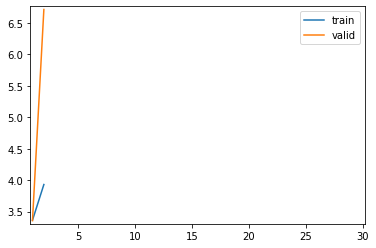

 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
metrics: (0.03130711480711481, 0.020203797812493464, 0.04548772685729208, 0.02840903697539853)


KeyboardInterrupt: 

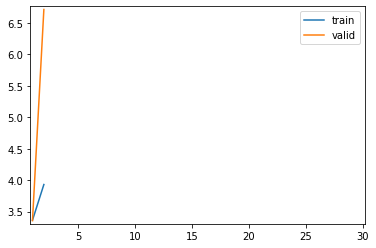

In [ ]:
#export
NUM_EPOCHS = 30
fit.fit(NUM_EPOCHS, model_path=os.path.join(config.MODEL_PATH/'ner_model.pth'))

In [ ]:
c = torch.zeros((12,))

In [ ]:
c

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
c[[2, 4, 5]] = 1; c

tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.])

In [ ]:
c[torch.nonzero(c).flatten()]

tensor([1., 1., 1.])